<i>Copyright (c) Microsoft Corporation.</i>

<i>Licensed under the MIT License.</i>

# Automated Machine Learning (AutoML) on Azure for Retail Sales Forecasting

This notebook demonstrates how to apply [AutoML in Azure Machine Learning services](https://docs.microsoft.com/en-us/azure/machine-learning/concept-automated-ml) to train and tune machine learning models for forecasting product sales in retail. We will use the Orange Juice dataset to illustrate the steps of utilizing AutoML as well as how to combine an AutoML model with a custom model for better performance.

AutoML is a process of automating the tasks of machine learning model development. It helps data scientists and other practioners build machine learning models with high scalability and quality in less amount of time. AutoML in Azure Machine Learning allows you to train and tune a model using a target metric that you specify. This service iterates through machine learning algorithms and feature selection approaches, producing a score that measures the quality of each machine learning pipeline. The best model will then be selected based on the scores. For more technical details about Azure AutoML, please check [this paper](https://papers.nips.cc/paper/7595-probabilistic-matrix-factorization-for-automated-machine-learning.pdf).

This notebook uses [Azure ML SDK](https://docs.microsoft.com/en-us/python/api/overview/azureml-sdk/?view=azure-ml-py) which is included in the `forecasting_env` conda environment. If you are running in Azure Notebooks or another Microsoft managed environment, the SDK is already installed. On the other hand, if you are running this notebook in your own environment, please follow [SDK installation instructions](https://docs.microsoft.com/azure/machine-learning/service/how-to-configure-environment) to install the SDK.

## Global Settings and Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import math
import datetime
import logging
import azureml.core
import azureml.automl
import pandas as pd

from matplotlib import pyplot as plt
from fclib.common.utils import git_repo_path
from fclib.evaluation.evaluation_utils import MAPE
from fclib.dataset.ojdata import download_ojdata, FIRST_WEEK_START
from fclib.common.utils import align_outputs
from fclib.models.multiple_linear_regression import fit, predict

from azureml.core import Workspace
from azureml.core.dataset import Dataset
from azureml.core.experiment import Experiment
from automl.client.core.common import constants
from azureml.train.automl import AutoMLConfig
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.automl.core._vendor.automl.client.core.common import metrics

print("System version: {}".format(sys.version))
print("This notebook was created using version 1.0.85 of the Azure ML SDK")
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

System version: 3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 21:14:29) 
[GCC 7.3.0]
This notebook was created using version 1.0.85 of the Azure ML SDK
You are currently using version 1.0.85 of the Azure ML SDK


In [3]:
# Use False if you've already downloaded and split the data
DOWNLOAD_SPLIT_DATA = True

# Data directory
DATA_DIR = os.path.join(git_repo_path(), "ojdata")

# Forecasting settings
HORIZON = 2
LAST_WEEK = 138

# Number of test periods
NUM_TEST_PERIODS = 3

# Column names
time_column_name = "week_start"
target_column_name = "move"
grain_column_names = ["store", "brand"]
index_column_names = [time_column_name] + grain_column_names

# Subset of stores used in the notebook
USE_STORES = [2, 5, 8]

## Set up Azure Machine Learning Workspace

An Azure ML workspace is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, deployment, inference, and the monitoring of deployed models. To create an Azure ML workspace, first you need access to an Azure subscription. An Azure subscription allows you to manage storage, compute, and other assets in the Azure cloud. You can [create a new subscription](https://azure.microsoft.com/en-us/free/) or access existing subscription information from the [Azure portal](https://portal.azure.com/). Given that you have access to your Azure subscription, you can further create an Azure ML workspace by following the instructions [here](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-manage-workspace). You can also do so [using Azure CLI](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-manage-workspace-cli) or the `Workspace.create()` method in Azure SDK.

In the following cell, please replace the value of each parameter with the value of the corresponding attribute of your workspace.

In [4]:
subscription_id = "<my-subscription-id>"
resource_group = "<my-resource-group>"
workspace_name = "<my-workspace-name>"
workspace_region = "eastus2"

### Access Azure ML Workspace

In what follows, we use Azure ML SDK to attempt to load the workspace specified by your parameters. The cell can fail if the specified workspace doesn't exist or you don't have permissions to access it. Hence, you may need to log into your Azure account and change the default subscription to the one which the workspace belongs to using Azure CLI `az account set --subscription <name or id>`.

In [6]:
try:
    ws = Workspace(subscription_id=subscription_id, resource_group=resource_group, workspace_name=workspace_name)
    # write the details of the workspace to a configuration file to the notebook library
    ws.write_config()
    print("Workspace configuration succeeded. Skip the workspace creation steps below")
except ValueError:
    raise Exception("Workspace not accessible. Change your parameters or create a new workspace below")

Workspace configuration succeeded. Skip the workspace creation steps below


### Create compute resources for your experiments

We run AutoML on a dynamically scalable compute cluster. To create a compute cluster, you need to specify a compute configuration that specifies the type of machine to be used and the scalability behaviors. Then you choose a name for the cluster that is unique within the workspace that can be used to address the cluster later.

In [7]:
# Choose a name for your CPU cluster
cpu_cluster_name = "cpu-cluster"

# Verify that cluster does not exist already
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print("Found existing cpu-cluster")
except ComputeTargetException:
    raise Exception("Creating new cpu-cluster")
    # print("Creating new cpu-cluster")

    # Specify the configuration for the new cluster
    compute_config = AmlCompute.provisioning_configuration(vm_size="STANDARD_D2_V2", min_nodes=4, max_nodes=4)

    # Create the cluster with the specified name and configuration
    cpu_cluster = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

    # Wait for the cluster to complete, show the output log
    cpu_cluster.wait_for_completion(show_output=True)

Found existing cpu-cluster


### Define Experiment

To run AutoML, you need to create an Experiment. An Experiment corresponds to a prediction problem you are trying to solve, while a Run corresponds to a specific approach to the problem.

In [8]:
# choose a name for the run history container in the workspace
experiment_name = "automl-ojforecasting"

experiment = Experiment(ws, experiment_name)

output = {}
output["SDK version"] = azureml.core.VERSION
output["Workspace"] = ws.name
output["SKU"] = ws.sku
output["Resource Group"] = ws.resource_group
output["Location"] = ws.location
output["Run History Name"] = experiment_name
pd.set_option("display.max_colwidth", -1)
outputDf = pd.DataFrame(data=output, index=[""])
outputDf.T

,
SDK version,1.0.85
Workspace,chhamlws
SKU,Basic
Resource Group,chhamlwsrg
Location,westcentralus
Run History Name,automl-ojforecasting


## Data Preparation

We need to download the Orange Juice data and split it into training and test sets. By default, the following cell will download and spit the data. If you've already done so, you may skip this part by switching `DOWNLOAD_SPLIT_DATA` to `False`.

We store the training data and test data using dataframes. The training data includes `train_df` and `aux_df` with `train_df` containing the historical sales up to week 135 (the time we make forecasts) and `aux_df` containing price/promotion information up until week 138. We assume that future price and promotion information up to a certain number of weeks ahead is predetermined and known. The test data is stored in `test_df` which contains the sales of each product in week 137 and 138. Assuming the current week is week 135, our goal is to forecast the sales in week 137 and 138 using the training data. There is a one-week gap between the current week and the first target week of forecasting as we want to leave time for planning inventory in practice.

### Data download and split

In [9]:
if DOWNLOAD_SPLIT_DATA:
    download_ojdata(DATA_DIR)
    df = pd.read_csv(os.path.join(DATA_DIR, "yx.csv"))
    df = df.loc[df.week <= LAST_WEEK]

Data already exists at the specified location.


In [10]:
# Convert logarithm of the unit sales to unit sales
df["move"] = df["logmove"].apply(lambda x: round(math.exp(x)))
# Add timestamp column
df["week_start"] = df["week"].apply(lambda x: FIRST_WEEK_START + datetime.timedelta(days=(x - 1) * 7))
# Select a subset of stores for demo purpose
df_sub = df[df.store.isin(USE_STORES)]

In [11]:
# Split data into training and test sets
def split_last_n_by_grain(df, n):
    """Group df by grain and split on last n rows for each group."""
    df_grouped = df.sort_values(time_column_name).groupby(  # Sort by ascending time
        grain_column_names, group_keys=False
    )
    df_head = df_grouped.apply(lambda dfg: dfg.iloc[:-n])
    df_tail = df_grouped.apply(lambda dfg: dfg.iloc[-n:])
    return df_head, df_tail


train_df, test_df = split_last_n_by_grain(df_sub, NUM_TEST_PERIODS)
train_df.reset_index(drop=True)
test_df.reset_index(drop=True)

# Save data locally
local_data_pathes = [
    os.path.join(DATA_DIR, "train.csv"),
    os.path.join(DATA_DIR, "test.csv"),
]

train_df.to_csv(local_data_pathes[0], index=None, header=True)
test_df.to_csv(local_data_pathes[1], index=None, header=True)

### Upload data to datastore

The [Machine Learning service workspace](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-workspace), is paired with the storage account, which contains the default data store. We will use it to upload the train and test data and create [tabular datasets](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.tabulardataset?view=azure-ml-py) for training and testing. A tabular dataset defines a series of lazily-evaluated, immutable operations to load data from the data source into tabular representation.


In [12]:
datastore = ws.get_default_datastore()
datastore.upload_files(files=local_data_pathes, target_path="dataset/", overwrite=True, show_progress=True)

Uploading an estimated of 2 files
Uploading /data/home/chenhui/work/forecasting/ojdata/test.csv
Uploading /data/home/chenhui/work/forecasting/ojdata/train.csv
Uploaded /data/home/chenhui/work/forecasting/ojdata/test.csv, 1 files out of an estimated total of 2
Uploaded /data/home/chenhui/work/forecasting/ojdata/train.csv, 2 files out of an estimated total of 2
Uploaded 2 files


$AZUREML_DATAREFERENCE_53167d5545f3467a95e63128d6c78d05

### Create dataset for training

In [13]:
train_dataset = Dataset.Tabular.from_delimited_files(path=datastore.path("dataset/train.csv"))

In [14]:
train_dataset.to_pandas_dataframe().tail()

,store,brand,week,logmove,constant,price1,price2,price3,price4,price5,...,price7,price8,price9,price10,price11,deal,feat,profit,move,week_start
2976,8,11,131,10.40,1,0.03,0.04,0.04,0.03,0.03,...,0.04,0.03,0.02,0.02,0.02,0,0.00,5.52,33024,1992-03-12
2977,8,11,132,10.39,1,0.03,0.04,0.04,0.04,0.03,...,0.03,0.03,0.02,0.02,0.02,1,1.00,5.48,32384,1992-03-19
2978,8,11,133,9.37,1,0.05,0.04,0.04,0.03,0.04,...,0.03,0.03,0.02,0.02,0.02,0,0.00,5.38,11776,1992-03-26
2979,8,11,134,9.34,1,0.04,0.04,0.04,0.03,0.03,...,0.04,0.03,0.02,0.02,0.02,0,0.00,7.16,11392,1992-04-02
2980,8,11,135,10.51,1,0.04,0.04,0.04,0.04,0.03,...,0.04,0.03,0.03,0.02,0.02,1,1.00,8.29,36864,1992-04-09


## Modeling

For forecasting tasks, AutoML uses pre-processing and estimation steps that are specific to time-series. AutoML will undertake the following pre-processing steps:
* Detect time-series sample frequency (e.g. hourly, daily, weekly) and create new records for absent time points to make the series regular. A regular time series has a well-defined frequency and has a value at every sample point in a contiguous time span
* Impute missing values in the target (via forward-fill) and feature columns (using median column values)
* Create grain-based features to enable fixed effects across different series
* Create time-based features to assist in learning seasonal patterns
* Encode categorical variables to numeric quantities

In this notebook, AutoML will train a single, regression-type model across all time-series in a given training set. This allows the model to generalize across related series. To create a training job, we use AutoML Config object to define the settings and data. Here is a summary of the meanings of the AutoMLConfig parameters:

|Property|Description|
|-|-|
|**task**|forecasting|
|**primary_metric**|This is the metric that you want to optimize.<br> Forecasting supports the following primary metrics <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>
|**experiment_timeout_hours**|Experimentation timeout in hours.|
|**enable_early_stopping**|If early stopping is on, training will stop when the primary metric is no longer improving.|
|**training_data**|Input dataset, containing both features and label column.|
|**label_column_name**|The name of the label column.|
|**compute_target**|The remote compute for training.|
|**n_cross_validations**|Number of cross-validation folds to use for model/pipeline selection|
|**enable_voting_ensemble**|Allow AutoML to create a Voting ensemble of the best performing models|
|**enable_stack_ensemble**|Allow AutoML to create a Stack ensemble of the best performing models|
|**debug_log**|Log file path for writing debugging information|
|**time_column_name**|Name of the datetime column in the input data|
|**grain_column_names**|Name(s) of the columns defining individual series in the input data|
|**drop_column_names**|Name(s) of columns to drop prior to modeling|
|**max_horizon**|Maximum desired forecast horizon in units of time-series frequency|

### Model training

In [15]:
time_series_settings = {
    "time_column_name": time_column_name,
    "grain_column_names": grain_column_names,
    "drop_column_names": ["logmove"],  # 'logmove' is a leaky feature, so we remove it.
    "max_horizon": NUM_TEST_PERIODS,
}

automl_config = AutoMLConfig(
    task="forecasting",
    debug_log="automl_oj_sales_errors.log",
    primary_metric="normalized_mean_absolute_error",
    experiment_timeout_hours=0.6,  # You may increase this number to improve model accuracy
    training_data=train_dataset,
    label_column_name=target_column_name,
    compute_target=cpu_cluster,
    enable_early_stopping=True,
    n_cross_validations=3,
    verbosity=logging.INFO,
    **time_series_settings
)

In [16]:
remote_run = experiment.submit(automl_config, show_output=False)
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-ojforecasting,AutoML_911f7e42-269a-4b6e-80ea-8f3cc241fc9b,automl,Starting,Link to Azure Machine Learning studio,Link to Documentation


In [ ]:
remote_run.wait_for_completion()

### Retrieve the best model

Each run within an Experiment stores serialized (i.e. pickled) pipelines from the AutoML iterations. After the training job is done, we can retrieve the pipeline with the best performance on the validation dataset.

In [18]:
best_run, fitted_model = remote_run.get_output()
print(fitted_model.steps)
model_name = best_run.properties["model_name"]

[('timeseriestransformer', TimeSeriesTransformer(logger=None,
           pipeline_type=<TimeSeriesPipelineType.FULL: 1>)), ('prefittedsoftvotingregressor', PreFittedSoftVotingRegressor(estimators=[('9', Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('gradientboostingregressor', GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=10,
             max_features='s...mators=10, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False))]))],
               flatten_transform=None,
               weights=[0.5333333333333333, 0.4, 0.06666666666666667]))]


## Forecasting

Now that we have retrieved the best model pipeline, we can apply it to generate forecasts for the target weeks. To do this, we first remove the target values from the test set

### Generate forecasts

In [19]:
X_test = test_df
y_test = X_test.pop(target_column_name).values

In [20]:
X_test.head()

,store,brand,week,logmove,constant,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,price11,deal,feat,profit,week_start
85,2,1,136,8.59,1,0.05,0.05,0.05,0.05,0.04,0.05,0.03,0.04,0.03,0.02,0.03,0,0.00,33.54,1992-04-16
86,2,1,137,9.19,1,0.04,0.05,0.05,0.04,0.03,0.04,0.03,0.04,0.04,0.02,0.03,0,0.00,20.43,1992-04-23
87,2,1,138,9.74,1,0.04,0.04,0.05,0.04,0.04,0.05,0.04,0.04,0.04,0.03,0.03,1,1.00,11.29,1992-04-30
195,2,2,136,9.14,1,0.05,0.05,0.05,0.05,0.04,0.05,0.03,0.04,0.03,0.02,0.03,1,0.00,27.13,1992-04-16
196,2,2,137,8.74,1,0.04,0.05,0.05,0.04,0.03,0.04,0.03,0.04,0.04,0.02,0.03,0,0.00,33.30,1992-04-23


In [21]:
# The featurized data, aligned to y, will also be returned. It contains the assumptions
# that were made in the forecast and helps align the forecast to the original data.
y_predictions, X_trans = fitted_model.forecast(X_test)

We need to align the output explicitly to the input, as the count and order of the rows may have changed during transformations that span multiple rows.

In [22]:
pred_automl = align_outputs(y_predictions, X_trans, X_test, y_test, target_column_name)
pred_automl.head()

,week_start,store,brand,predicted,week,logmove,constant,price1,price2,price3,...,price6,price7,price8,price9,price10,price11,deal,feat,profit,move
0,1992-04-16,2,1,5991.08,136,8.59,1,0.05,0.05,0.05,...,0.05,0.03,0.04,0.03,0.02,0.03,0,0.00,33.54,5376
1,1992-04-16,2,2,7928.07,136,9.14,1,0.05,0.05,0.05,...,0.05,0.03,0.04,0.03,0.02,0.03,1,0.00,27.13,9312
2,1992-04-16,2,3,3632.54,136,7.85,1,0.05,0.05,0.05,...,0.05,0.03,0.04,0.03,0.02,0.03,0,0.00,32.55,2560
3,1992-04-16,2,4,4468.13,136,7.42,1,0.05,0.05,0.05,...,0.05,0.03,0.04,0.03,0.02,0.03,0,0.00,34.98,1664
4,1992-04-16,2,5,5546.81,136,8.59,1,0.05,0.05,0.05,...,0.05,0.03,0.04,0.03,0.02,0.03,0,0.00,28.80,5376


### Results evaluation & visualization

[Test data scores]

explained_variance:   0.364
r2_score:   0.360
spearman_correlation:   0.792
mean_absolute_percentage_error:   112.272
mean_absolute_error:   6826.193
normalized_mean_absolute_error:   0.047
median_absolute_error:   3039.239
normalized_median_absolute_error:   0.021
root_mean_squared_error:   14651.061
normalized_root_mean_squared_error:   0.101
root_mean_squared_log_error:   0.810
normalized_root_mean_squared_log_error:   0.128


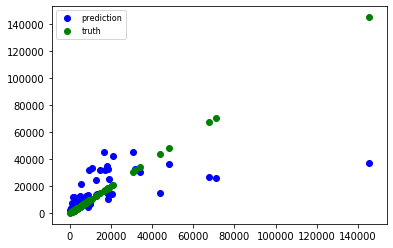

In [23]:
# Use automl metrics module
scores = metrics.compute_metrics_regression(
    pred_automl["predicted"],
    pred_automl[target_column_name],
    list(constants.Metric.SCALAR_REGRESSION_SET),
    None,
    None,
    None,
)

print("[Test data scores]\n")
for key, value in scores.items():
    print("{}:   {:.3f}".format(key, value))

# Plot outputs
%matplotlib inline
test_pred = plt.scatter(pred_automl[target_column_name], pred_automl["predicted"], color="b")
test_test = plt.scatter(pred_automl[target_column_name], pred_automl[target_column_name], color="g")
plt.legend((test_pred, test_test), ("prediction", "truth"), loc="upper left", fontsize=8)
plt.show()

We also compute MAPE of the forecasts in the last two weeks of the forecast period in order to be consistent with the evaluation period that is used in other quick start examples.

In [24]:
pred_automl_sub = pred_automl.loc[pred_automl.week > max(test_df.week) - HORIZON]
mape_automl_sub = MAPE(pred_automl_sub["predicted"], pred_automl_sub["move"]) * 100
print("MAPE of forecasts obtained by AutoML in the last two weeks: " + str(mape_automl_sub))

MAPE of forecasts obtained by AutoML in the last two weeks: 116.89068077180539


## Combine AutoML Model with a Custom Model

So far we have demonstrated how we can quickly build a forecasting model with AutoML in Azure. Next, we further show a simple way to achieve more robust and accurate forecasts by combining the forecasts from AutoML and a custom model that the user may have. Here we assume that the user have also constructed a series of linear regression models with each model forecasts the sales of a specfic store-brand using `scikit-learn` package.

### Multiple linear regression models

In [25]:
# Create price features
df_sub["price"] = df_sub.apply(lambda x: x.loc["price" + str(int(x.loc["brand"]))], axis=1)
price_cols = [
    "price1",
    "price2",
    "price3",
    "price4",
    "price5",
    "price6",
    "price7",
    "price8",
    "price9",
    "price10",
    "price11",
]
df_sub["avg_price"] = df_sub[price_cols].sum(axis=1).apply(lambda x: x / len(price_cols))
df_sub["price_ratio"] = df_sub.apply(lambda x: x["price"] / x["avg_price"], axis=1)

# Create lag features on unit sales
df_sub["move_lag1"] = df_sub["move"].shift(1)
df_sub["move_lag2"] = df_sub["move"].shift(2)

# Drop rows with NaN values
df_sub.dropna(inplace=True)

After splitting the data, we use `fit()` and `predit()` functions from `fclib.models.multiple_linear_regression` to train separate linear regression model for each invididual time series and generate forecasts for the sales during the test period.

In [26]:
# Split data into training and test sets
train_df, test_df = split_last_n_by_grain(df_sub, NUM_TEST_PERIODS)
train_df.reset_index(drop=True)
test_df.reset_index(drop=True)

# Train multiple linear regression models
fea_column_names = ["move_lag1", "move_lag2", "price", "price_ratio"]
lr_models = fit(train_df, grain_column_names, fea_column_names, target_column_name)

# Generate forecasts with the trained models
pred_all = predict(test_df, lr_models, time_column_name, grain_column_names, fea_column_names)

pred_lr = pd.merge(pred_all, test_df, on=index_column_names)
pred_lr.head()

,week_start,prediction,store,brand,week,logmove,constant,price1,price2,price3,...,price11,deal,feat,profit,move,price,avg_price,price_ratio,move_lag1,move_lag2
0,1992-04-16,12507,2,1,136,8.59,1,0.05,0.05,0.05,...,0.03,0,0.00,33.54,5376,0.05,0.04,1.27,12416.00,28096.00
1,1992-04-23,17664,2,1,137,9.19,1,0.04,0.05,0.05,...,0.03,0,0.00,20.43,9792,0.04,0.04,1.11,5376.00,12416.00
2,1992-04-30,21670,2,1,138,9.74,1,0.04,0.04,0.05,...,0.03,1,1.00,11.29,16960,0.04,0.04,0.94,9792.00,5376.00
3,1992-04-16,9551,2,2,136,9.14,1,0.05,0.05,0.05,...,0.03,1,0.00,27.13,9312,0.05,0.04,1.21,11424.00,4992.00
4,1992-04-23,7452,2,2,137,8.74,1,0.04,0.05,0.05,...,0.03,0,0.00,33.30,6240,0.05,0.04,1.39,9312.00,11424.00


Let's check the accuracy of the predictions on the entire forecast period as well as in the last two weeks of the forecast period.





In [27]:
mape_lr_entire = MAPE(pred_lr["prediction"], pred_lr["move"]) * 100
print("MAPE of forecasts obtained by multiple linear regression on entire test period: " + str(mape_lr_entire))

MAPE of forecasts obtained by multiple linear regression on entire test period: 83.90865445283927


In [28]:
pred_lr_sub = pred_lr.loc[pred_lr.week > max(test_df.week) - HORIZON]
mape_lr_sub = MAPE(pred_lr_sub["prediction"], pred_lr_sub["move"]) * 100
print("MAPE of forecasts obtained by multiple linear regression in the last two weeks: " + str(mape_lr_sub))

MAPE of forecasts obtained by multiple linear regression in the last two weeks: 72.11741385279376


### Combine forecasts from different methods

We can combine the forecasts obtained by AutoML and multiple linear regression using weighted average and evaluate the final forecasts. Usually the combined forecasts will be more robust as a combination of two methods can reduce the chance of model overfitting. Here we use equal weights which can be further adjusted according to our confidence on each model.

In [29]:
pred_final = pd.merge(
    pred_automl[index_column_names + ["predicted", "move", "week"]],
    pred_lr[index_column_names + ["prediction"]],
    on=index_column_names,
    how="left",
)
pred_final["combined_prediction"] = pred_final["predicted"] * 0.5 + pred_final["prediction"] * 0.5

In [30]:
mape_entire = MAPE(pred_final["combined_prediction"], pred_final["move"]) * 100
print("MAPE of forecasts obtained by the combined model on entire test period: " + str(mape_entire))

MAPE of forecasts obtained by the combined model on entire test period: 83.98215920392276


In [31]:
pred_final_sub = pred_final.loc[pred_final.week > max(test_df.week) - HORIZON]
mape_final_sub = MAPE(pred_final_sub["combined_prediction"], pred_final_sub["move"]) * 100
print("MAPE of forecasts obtained by the combined model in the last two weeks: " + str(mape_final_sub))

MAPE of forecasts obtained by the combined model in the last two weeks: 78.91800649880321


## Additional Reading

\[1\] Nicolo Fusi, Rishit Sheth, and Melih Elibol. 2018. Probabilistic Matrix Factorization for Automated Machine Learning. In Advances in Neural Information Processing Systems. 3348-3357.<br>
\[2\] Azure AutoML Package Docs: https://docs.microsoft.com/en-us/python/api/azureml-train-automl/azureml.train.automl?view=azure-ml-py <br>
\[3\] Azure Automated Machine Learning Examples: https://github.com/Azure/MachineLearningNotebooks/tree/master/how-to-use-azureml/automated-machine-learning <br>


